In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
project_dir = '/content/drive/MyDrive/Assignment'
os.makedirs(project_dir, exist_ok=True)
print(f"Project directory: {project_dir}")

Mounted at /content/drive
Project directory: /content/drive/MyDrive/Assignment


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

Using device: cuda
GPU: Tesla T4
PyTorch version: 2.8.0+cu126
Torchvision version: 0.23.0+cu126


In [7]:

CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2470, 0.2435, 0.2616)

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])


test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {test_dataset.classes}")

100%|██████████| 170M/170M [00:09<00:00, 18.6MB/s]


Test samples: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
class TransformerBlock(nn.Module):

    def __init__(self, dim, n_heads, mlp_ratio=4., drop=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, n_heads, dropout=drop, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)

        mlp_hidden = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(mlp_hidden, dim),
            nn.Dropout(drop)
        )

    def forward(self, x):
        normed = self.norm1(x)
        attn_out, _ = self.attn(normed, normed, normed)
        x = x + attn_out
        x = x + self.mlp(self.norm2(x))
        return x


class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, num_classes=10,
                 embed_dim=384, depth=8, n_heads=6, mlp_ratio=4., drop_rate=0.1):
        super().__init__()

        n_patches = (img_size // patch_size) ** 2

        # Patch embedding
        self.patch_embed = nn.Conv2d(in_channels, embed_dim,
                                     kernel_size=patch_size, stride=patch_size)

        # CLS token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # Positional embeddings
        self.pos_embed = nn.Parameter(torch.zeros(1, n_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(drop_rate)

        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, n_heads, mlp_ratio, drop_rate)
            for _ in range(depth)
        ])

        # Classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        # Initialize
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        B = x.shape[0]

        # Patchify
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)

        # Add CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)

        # Add positional embeddings
        x = x + self.pos_embed
        x = self.pos_drop(x)

        # Transformer blocks
        for block in self.blocks:
            x = block(x)

        # Classify from CLS token
        x = self.norm(x)
        cls_output = x[:, 0]
        x = self.head(cls_output)

        return x

print("Model architecture defined")

Model architecture defined


In [4]:
# Create model instance
model = VisionTransformer(
    img_size=32,
    patch_size=4,
    in_channels=3,
    num_classes=10,
    embed_dim=384,
    depth=8,
    n_heads=6,
    mlp_ratio=4.,
    drop_rate=0.1
).to(device)

# Load trained weights
checkpoint = torch.load(f'{project_dir}/best_model.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


print(f"Model trained for {checkpoint['epoch']+1} epochs")
print(f"Best validation accuracy: {checkpoint['best_acc']:.2f}%")

# Model info
total_params = sum(p.numel() for p in model.parameters())
print(f"\nModel Configuration:")
print(f"- Patch Size: 4x4")
print(f"- Embedding Dim: 384")
print(f"- Depth: 8 blocks")
print(f"- Attention Heads: 6")
print(f"- Total Parameters: {total_params:,}")

Model trained for 89 epochs
Best validation accuracy: 84.22%

Model Configuration:
- Patch Size: 4x4
- Embedding Dim: 384
- Depth: 8 blocks
- Attention Heads: 6
- Total Parameters: 14,244,490


In [9]:
print("\nEvaluating on CIFAR-10 test set...")
print("=" * 70)

model.eval()
correct = 0
total = 0
class_correct = [0] * 10
class_total = [0] * 10

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing'):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Per-class accuracy
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

# Overall accuracy
test_accuracy = 100. * correct / total

print("\n" + "=" * 70)
print(f"FINAL TEST ACCURACY: {test_accuracy:.2f}%")
print("=" * 70)

# Per-class accuracy
print("\nPer-Class Accuracy:")
print("-" * 70)
classes = test_dataset.classes
for i in range(10):
    acc = 100. * class_correct[i] / class_total[i]
    print(f"{classes[i]:15s}: {acc:5.2f}% ({class_correct[i]:4d}/{class_total[i]:4d})")

print("\n" + "=" * 70)
print(f"Final: {test_accuracy:.2f}%")
print("=" * 70)


Evaluating on CIFAR-10 test set...


Testing: 100%|██████████| 79/79 [00:07<00:00, 11.17it/s]


FINAL TEST ACCURACY: 84.22%

Per-Class Accuracy:
----------------------------------------------------------------------
airplane       : 85.70% ( 857/1000)
automobile     : 92.20% ( 922/1000)
bird           : 79.70% ( 797/1000)
cat            : 73.10% ( 731/1000)
deer           : 81.60% ( 816/1000)
dog            : 76.00% ( 760/1000)
frog           : 87.10% ( 871/1000)
horse          : 89.00% ( 890/1000)
ship           : 88.90% ( 889/1000)
truck          : 88.90% ( 889/1000)

Final: 84.22%


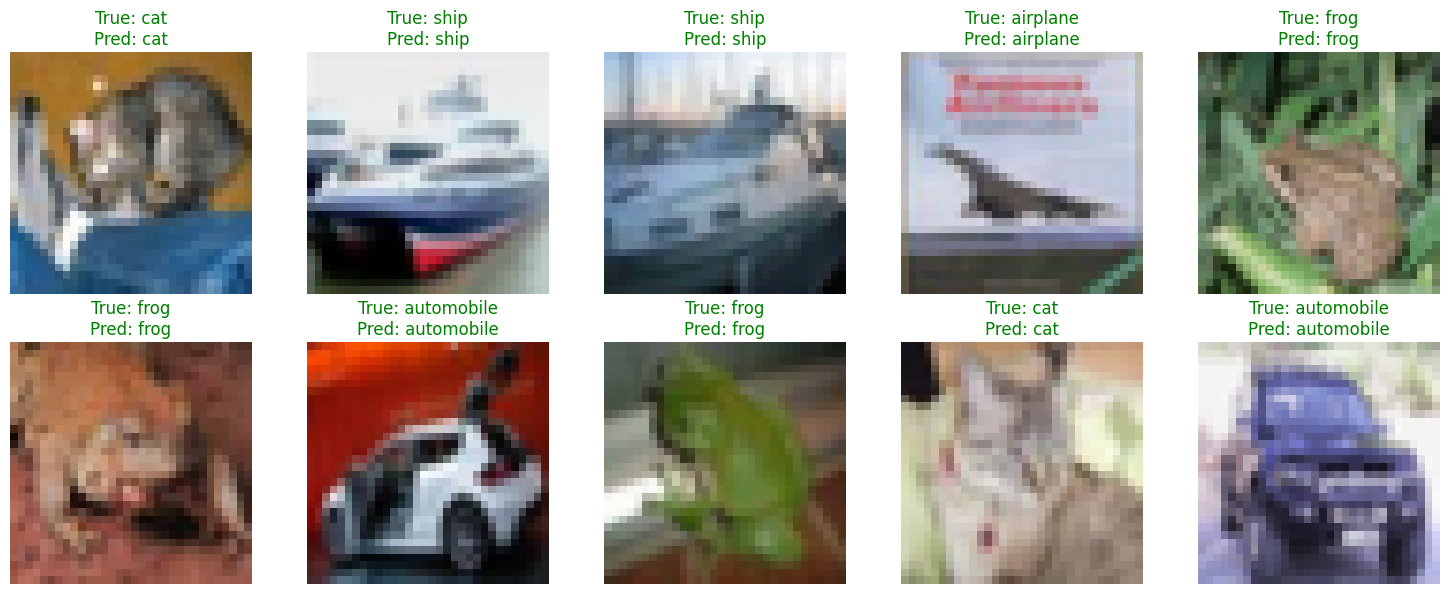

In [14]:

def denormalize(img):
    img = img.cpu().numpy().transpose((1, 2, 0))
    img = img * np.array(CIFAR10_STD) + np.array(CIFAR10_MEAN)
    img = np.clip(img, 0, 1)
    return img

# Get a batch
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = outputs.max(1)

# Plot
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for idx, ax in enumerate(axes.flat):
    ax.imshow(denormalize(images[idx]))
    true_label = classes[labels[idx]]
    pred_label = classes[predicted[idx]]
    color = 'green' if predicted[idx] == labels[idx] else 'red'
    ax.set_title(f'True: {true_label}\nPred: {pred_label}', color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()
